In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
from fates_calibration.FATES_calibration_constants import FATES_PFT_IDS, FATES_INDEX
import fates_calibration.emulation_functions as emf
from fates_calibration.FATES_calibration_constants import OBS_MODEL_VARS, VAR_UNITS
from matplotlib.patches import Rectangle

2025-01-10 10:29:24.021059: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-10 10:29:25.436870: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-10 10:29:26.972665: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-10 10:29:26.973858: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-10 10:29:41.933298: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
def plot_parameter_hists(sample, param_list, default_param_data):
    
    pars = [par for par in sample.columns if par != 'wave']
    
    plt.figure(figsize=[18, 16])
    for i, par in enumerate(pars):
        p = get_default_value(par, param_list, default_param_data)
        ax = plt.subplot(7, 5, i + 1)
        ax.hist(sample[par])
        ax.axvline(x=p, color='r', linestyle='-')
        ax.set_xlabel(par)
        ax.set_xlim(0, 1)
    plt.tight_layout()

def get_param_samples(sample_dir):
    
    files = sorted([os.path.join(sample_dir, file) for file in os.listdir(sample_dir) if file.endswith(".csv")])
    sample_dfs = []
    for file in files:
        df = pd.read_csv(file, index_col=[0])
        sample_dfs.append(df)
    sample_df = pd.concat(sample_dfs)
    sample_df = sample_df.drop(columns=['wave'])

    return sample_df

def get_default_pars(lhckey, in_pars):
    
    lhkey_df = pd.read_csv(lhckey)
    lhkey_df = lhkey_df.drop(columns=['ensemble'])
    param_names = lhkey_df.columns

    default_pars = [par for par in param_names if par not in in_pars]

    return default_pars
    
def get_param_value(change_str, default_value, param_list_file,
                    parameter, type):
    
    if change_str == 'pft':
        pft_values = pd.read_excel(param_list_file,
                                   parameter.replace("fates_", ""))
        param_value = pft_values[type].values
    
    elif 'percent' in change_str:
        percent_change = get_percentage_change(change_str)
        if type == 'param_min':
            param_value = default_value - np.abs(default_value*(percent_change/100.0))
        else:
            param_value = default_value + np.abs(default_value*(percent_change/100.0))
    else:
        numeric_value = float(change_str)
        if default_value.size == 1:
            param_value = numeric_value
        else:
            param_value = np.full_like(default_value, numeric_value)

    if default_value.size == 1:
        if default_value == -999.9:
            param_value = -999.9
    else:
        param_value[default_value == -999.9] = -999.9

    return param_value
    
def get_percentage_change(param_change):
    return float(param_change.replace('percent', ''))

def unnormalize(value, min_value, max_value):
    return (max_value - min_value)*value + min_value
    
def normalize(value, min_value, max_value):
    return (value - min_value)/(max_value - min_value)

def get_default_value(parameter, param_list, default_param_data):

    if parameter == 'smpsc_delta':
        default_value = np.repeat(189000, 16)
    else:
        default_value = default_param_data[parameter].values
    
    sub = param_list[param_list.fates_parameter_name == parameter]
    change_str_min = str(sub['param_min'].values[0])
    change_str_max = str(sub['param_max'].values[0])
    
    min_value = get_param_value(change_str_min, default_value,
                                  param_list_file, parameter, 'param_min')
    max_value = get_param_value(change_str_max, default_value,
                                  param_list_file, parameter, 'param_max')
    
    rescaled_default = normalize(default_value, min_value, max_value)
    if parameter == 'fates_leaf_vcmax25top':
        rescaled_default_pft = rescaled_default[0, pft_index]
    else:
        rescaled_default_pft = rescaled_default[pft_index]

    return rescaled_default_pft

def get_rescaled_value(value, parameter, param_list, default_param_data):

    if parameter == 'smpsc_delta':
        default_value = np.repeat(189000, 16)
    else:
        default_value = default_param_data[parameter].values
    
    sub = param_list[param_list.fates_parameter_name == parameter]
    change_str_min = str(sub['param_min'].values[0])
    change_str_max = str(sub['param_max'].values[0])
    
    min_value = get_param_value(change_str_min, default_value,
                                  param_list_file, parameter, 'param_min')
    max_value = get_param_value(change_str_max, default_value,
                                  param_list_file, parameter, 'param_max')
    
    rescaled_value = unnormalize(value, min_value, max_value)
    if parameter == 'fates_leaf_vcmax25top':
        rescaled_value_pft = rescaled_value[0, pft_index]
    else:
        rescaled_value_pft = rescaled_value[pft_index]

    return rescaled_value_pft

def choose_pars(sample_df, var_choose, param_list, default_param_data):
    var_median = sample_df[var_choose].median()
    sample_df['var_diff'] = np.abs(sample_df[var_choose] - var_median)
    choose_index = np.argmin(sample_df.var_diff)
    sample_df = sample_df.drop(columns=['var_diff'])
    
    final_pars_scaled = sample_df.iloc[choose_index]
    pars = sample_df.columns
    
    final_pars = []
    for i, parval in enumerate(final_pars_scaled):
        final_pars.append(get_rescaled_value(parval, pars[i], param_list, default_param_data))
    
    final_pars_df = pd.DataFrame({'parameter': pars, 'value': final_pars})
    return final_pars_df

In [3]:
param_dir = '/glade/work/afoster/FATES_calibration/parameter_files'
fates_param_name = "fates_params_default_sci.1.78.3._api.36.1.0.nc"
param_list_name = "param_list_sci.1.78.3_api.36.1.0.xls"

default_param_file = os.path.join(param_dir, fates_param_name)
param_list_file = os.path.join(param_dir, param_list_name)

default_param_data = xr.open_dataset(default_param_file, decode_cf=False)
param_list = pd.read_excel(param_list_file, sheet_name=0)

In [13]:
pfts = list(FATES_PFT_IDS.keys())
pfts

['broadleaf_evergreen_tropical_tree',
 'needleleaf_evergreen_extratrop_tree',
 'needleleaf_colddecid_extratrop_tree',
 'broadleaf_evergreen_extratrop_tree',
 'broadleaf_hydrodecid_tropical_tree',
 'broadleaf_colddecid_extratrop_tree',
 'broadleaf_evergreen_extratrop_shrub',
 'broadleaf_colddecid_extratrop_shrub',
 'broadleaf_evergreen_arctic_shrub',
 'broadleaf_colddecid_arctic_shrub',
 'arctic_c3_grass',
 'cool_c3_grass',
 'c4_grass',
 'c3_crop',
 'c3_irrigated']

In [14]:
pft = 'broadleaf_evergreen_tropical_tree'
pft_id = FATES_PFT_IDS[pft]
pft_index = FATES_INDEX[pft] - 1

In [15]:
lhckey = '/glade/work/afoster/FATES_calibration/parameter_files/fates_param_lh/fates_lh_key.csv'
sample_dir = f"/glade/u/home/afoster/FATES_Calibration/pft_output_gs1/{pft_id}_outputs/samples"

In [16]:
sample_df = get_param_samples(sample_dir)

In [27]:
sample_df.isna().any()

fates_leaf_stomatal_intercept              False
fates_leaf_vcmax25top                      False
fates_leafn_vert_scaler_coeff2             False
fates_rad_leaf_clumping_index              False
fates_turb_leaf_diameter                   False
fates_leaf_stomatal_slope_medlyn           False
fates_leafn_vert_scaler_coeff1             False
fates_maintresp_leaf_atkin2017_baserate    False
fates_nonhydro_smpso                        True
smpsc_delta                                 True
dtype: bool

In [28]:
sample_df.drop(['fates_nonhydro_smpso', 'smpsc_delta'], axis=1, inplace=True)

In [29]:
pars = sample_df.columns
default_pars = get_default_pars(lhckey, pars)

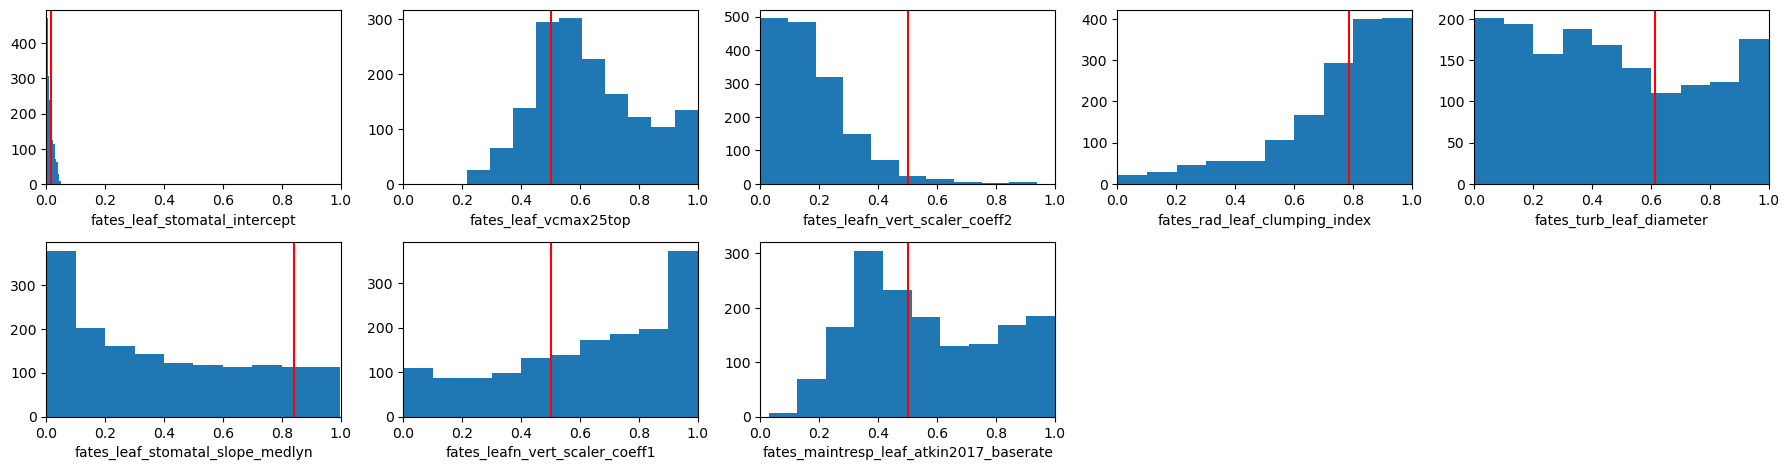

In [30]:
plot_parameter_hists(sample_df, param_list, default_param_data)

In [31]:
corr = sample_df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')
 .format(precision=2))

,fates_leaf_stomatal_intercept,fates_leaf_vcmax25top,fates_leafn_vert_scaler_coeff2,fates_rad_leaf_clumping_index,fates_turb_leaf_diameter,fates_leaf_stomatal_slope_medlyn,fates_leafn_vert_scaler_coeff1,fates_maintresp_leaf_atkin2017_baserate
fates_leaf_stomatal_intercept,nan,nan,nan,nan,nan,nan,nan,nan
fates_leaf_vcmax25top,-0.57,nan,nan,nan,nan,nan,nan,nan
fates_leafn_vert_scaler_coeff2,0.28,-0.47,nan,nan,nan,nan,nan,nan
fates_rad_leaf_clumping_index,0.30,-0.41,-0.14,nan,nan,nan,nan,nan
fates_turb_leaf_diameter,0.18,-0.45,0.40,0.31,nan,nan,nan,nan
fates_leaf_stomatal_slope_medlyn,-0.04,-0.31,-0.16,0.10,0.22,nan,nan,nan
fates_leafn_vert_scaler_coeff1,-0.07,0.29,0.34,-0.06,0.01,-0.13,nan,nan
fates_maintresp_leaf_atkin2017_baserate,0.85,-0.43,-0.02,0.24,-0.01,0.31,-0.02,nan


In [32]:
var_dat = pd.read_csv('/glade/u/home/afoster/FATES_Calibration/pft_vars_dompft_gs1.csv')
emulator_dir = '/glade/u/home/afoster/FATES_Calibration/pft_output_gs1/emulators'
vars_pft = var_dat[var_dat.pft == pft].vars.values.tolist()
vars = [var.replace('_implausibility', '') for var in vars_pft]
emulators = emf.load_all_emulators(pft_id, emulator_dir, vars)

In [33]:
var = 'GPP'
em = emulators[var]
pred_sampled, pred_sampled_var = em.predict(sample_df)

InvalidArgumentError: {{function_node __wrapped__GatherV2_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[8] = 8 is not in [0, 8) [Op:GatherV2]

True

In [22]:
obs_df_all = pd.read_csv('/glade/work/afoster/FATES_calibration/mesh_files/dominant_pft_grid_update.csv')
obs_df = obs_df_all[obs_df_all.pft == pft]
obs_mean = obs_df[f'{OBS_MODEL_VARS[var]}'].mean()
obs_var = obs_df[f'{OBS_MODEL_VARS[var]}_var'].mean()

ValueError: autodetected range of [nan, nan] is not finite

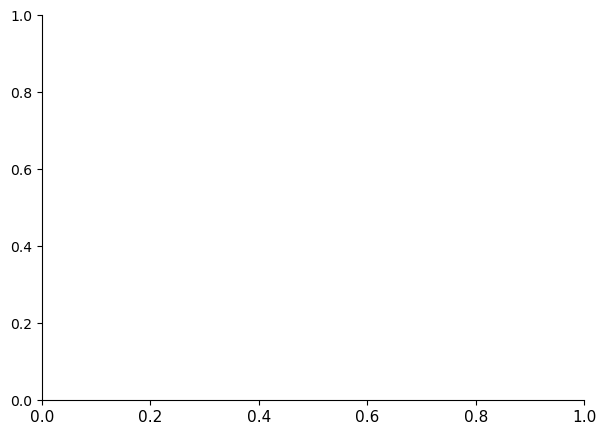

In [23]:
plt.figure(figsize=(7, 5))
ax = plt.subplot(111)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
plt.xticks(fontsize=11)

my_hist, _ = np.histogram(pred_sampled, bins=40)
maxv = my_hist.max()
plt.xlabel(f"Emulated {pft_id} Annual {var} ()", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.hist(pred_sampled, fc="darkgray", bins=40)
ax.add_patch(Rectangle((obs_mean - np.sqrt(obs_var), 0), 2*np.sqrt(obs_var), maxv,
                    facecolor='red', alpha=0.4))
ax.axvline(x=obs_mean, ymin=0.0, ymax=maxv, color='r')

In [ ]:
final_pars = choose_pars(sample_df, 'fates_leaf_vcmax25top')
final_pars['pft'] = pft
final_pars.to_csv(f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/final_pars.csv")

In [ ]:
# ALL PFTS

In [ ]:
final_par_dfs = []
dom_pfts = ['broadleaf_evergreen_tropical_tree', 'needleleaf_evergreen_extratrop_tree',
            'needleleaf_colddecid_extratrop_tree', 'arctic_c3_grass', 'cool_c3_grass',
            'c4_grass']
all_pfts = ['broadleaf_evergreen_tropical_tree', 'needleleaf_evergreen_extratrop_tree',
            'needleleaf_colddecid_extratrop_tree', 'arctic_c3_grass', 'cool_c3_grass',
            'c4_grass', 'broadleaf_evergreen_extratrop_tree', 'broadleaf_hydrodecid_tropical_tree',
           'broadleaf_colddecid_extratrop_tree', 'broadleaf_colddecid_extratrop_shrub', 'c3_crop',
            'c3_irrigated']
for pft in dom_pfts:
    pft_id = FATES_PFT_IDS[pft]
    df = pd.read_csv(f"/glade/u/home/afoster/FATES_Calibration/pft_output/{pft_id}_outputs/final_pars.csv",
                                    index_col=[0])
    df['pft_index'] = FATES_INDEX[pft]
    final_par_dfs.append(df)
final_par_df = pd.concat(final_par_dfs)

In [ ]:
np.unique(final_par_df.parameter)

In [ ]:
final_par_df[final_par_df.parameter == 'fates_leaf_vcmax25top']

In [ ]:
final_par_df.to_csv('/glade/u/home/afoster/FATES_Calibration/final_parameters.csv')